In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sc

In [4]:
# Import cleaned datasets
MRM=pd.read_csv('mean_ratings_yearmonth.csv')
# Next, reshape datasets

In [3]:
import statsmodels.api as sm
from random import random
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import acf,pacf,plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from matplotlib.backends.backend_pdf import PdfPages
from statsmodels.tsa.stattools import adfuller

In [5]:
# Consider months first
Months_M=MRM.pivot(index='rating_date',columns='genres',values='rating')

In [6]:
# I found something wrong with the assumption of seasonality

In [7]:
# Test seasonality
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

Action


<Figure size 432x288 with 0 Axes>

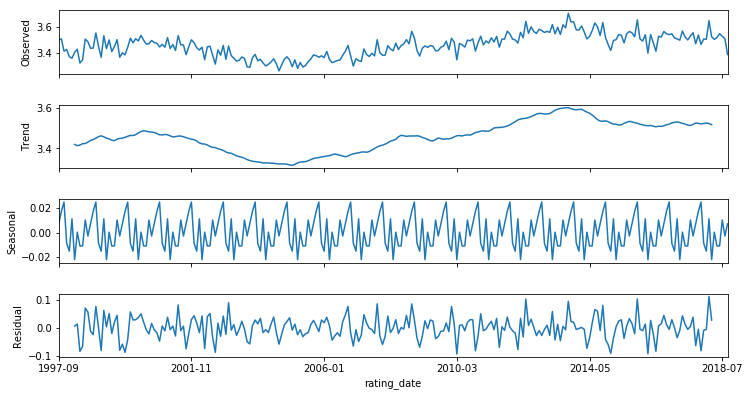

Adventure


<Figure size 432x288 with 0 Axes>

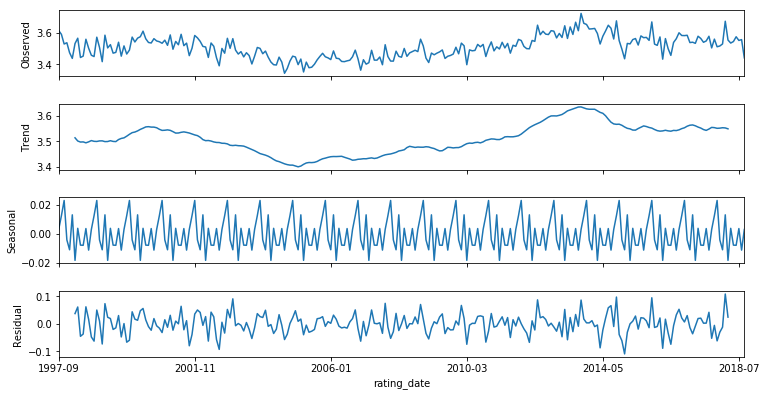

Comedy


<Figure size 432x288 with 0 Axes>

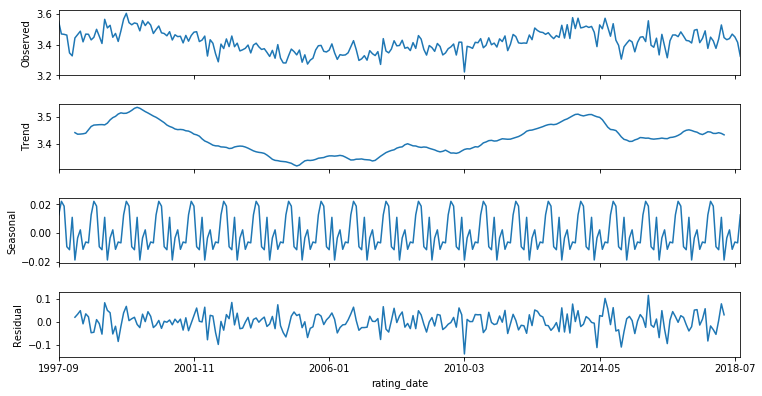

Crime


<Figure size 432x288 with 0 Axes>

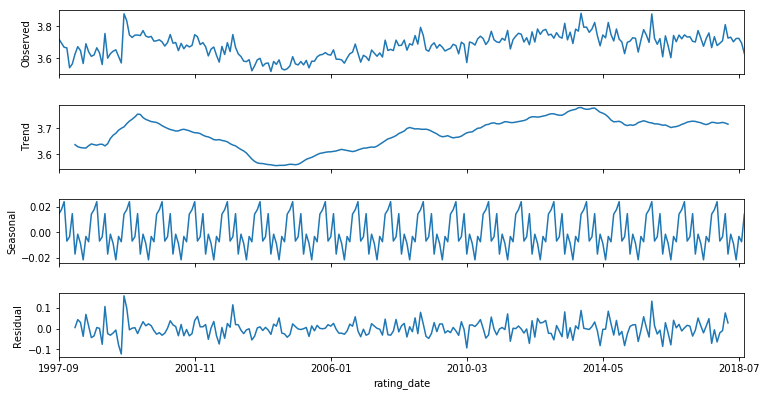

Drama


<Figure size 432x288 with 0 Axes>

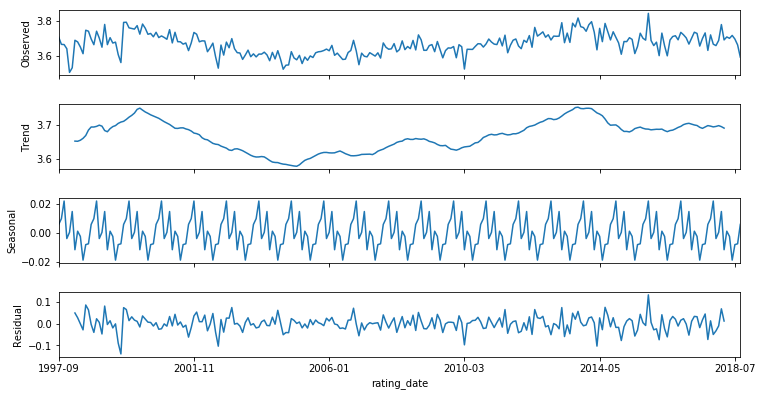

Fantasy


<Figure size 432x288 with 0 Axes>

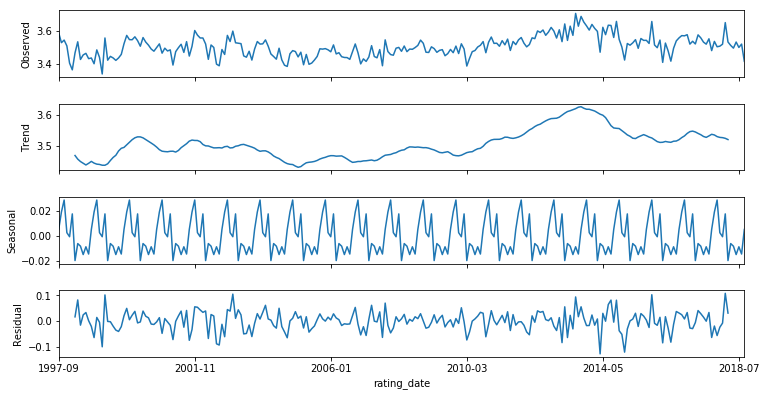

Romance


<Figure size 432x288 with 0 Axes>

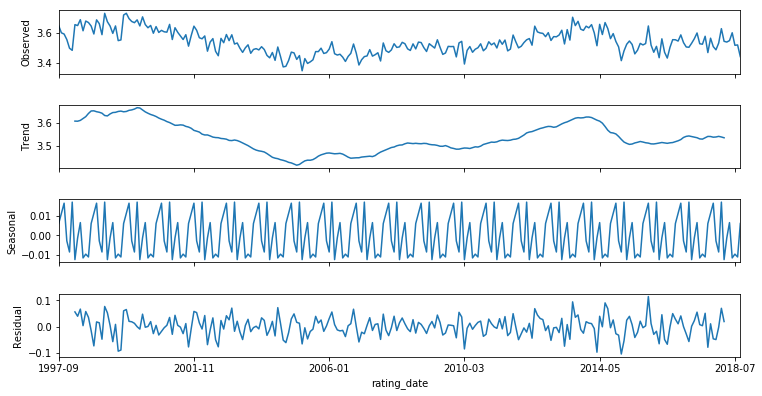

Sci-Fi


<Figure size 432x288 with 0 Axes>

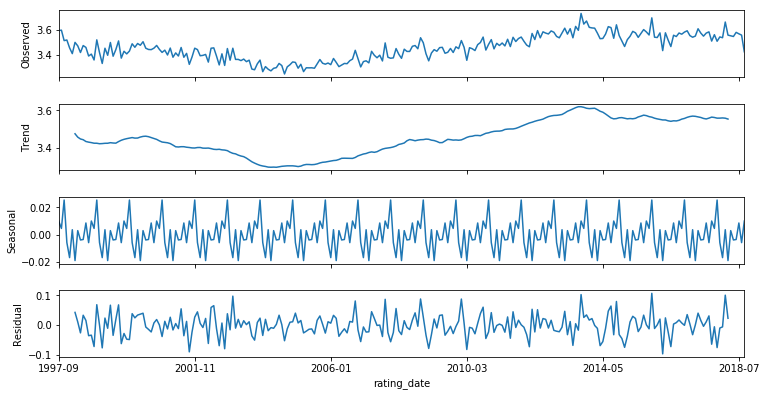

Thriller


<Figure size 432x288 with 0 Axes>

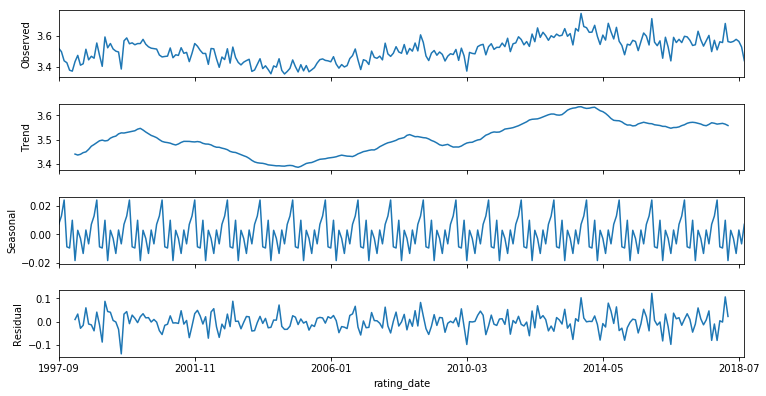

In [8]:
genres=list(Months_M.columns)
for i in genres:
    print(i)
    decomposition = seasonal_decompose(Months_M[i], freq=12)
    fig = plt.figure()  
    fig = decomposition.plot()  
    fig.set_size_inches(12, 6)
    plt.show()
#    fig

In [9]:
from pandas.plotting import autocorrelation_plot
# Something about the residuals
pdf=PdfPages("Hist.pdf")
for i in genres:
    decomposition = seasonal_decompose(Months_M[i], freq=12)
    s=(decomposition.resid).dropna()
    s.hist()
    plt.title('Hist of Resi_'+i)
    pdf.savefig()
    plt.close()
pdf.close()    

# All of them are close to Gaussian distribution

In [10]:
pdf=PdfPages('AutoCorrelation.pdf')
for i in genres:
    decomposition = seasonal_decompose(Months_M[i], freq=12)
    s=(decomposition.resid).dropna()
    autocorrelation_plot(s)
    plt.title('Autocorrelation_'+i)
    pdf.savefig()
    plt.close()
pdf.close()    
# The autocorrelation values are really small; then the residual can be regarded as white noise.

In [23]:
def TestStationaryAdfuller(ts, cutoff = 0.01):
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)

    if ts_test[1] <= cutoff:
        print('Reject--Stationary')
    else:
        print('Not reject--Not Stationary')

In [24]:
# First of all, test stationary
for i in Months_M.columns:
    print('Genre: '+i)
    TestStationaryAdfuller(Months_M[i])

Genre: Action
Test Statistic                  -2.041668
p-value                          0.268607
#Lags Used                       4.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64
Not reject--Not Stationary
Genre: Adventure
Test Statistic                  -2.495656
p-value                          0.116535
#Lags Used                       4.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64
Not reject--Not Stationary
Genre: Comedy
Test Statistic                  -2.337567
p-value                          0.160138
#Lags Used                       5.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)           

In [25]:
# After test, only the Fantasy series is stationary
# Then consider extracting the difference
Dif_DT=pd.DataFrame()
for i in Months_M.columns:
    if i!='Fantasy':
        Dif=Months_M[i]-Months_M[i].shift(1)
        # Remove the seasonal trend
        Dif_sea=Dif-Dif.shift(12)
        s='Dif_'+i
        Dif_DT[s]=Dif_sea
        print('Difference of '+i)
        TestStationaryAdfuller(Dif_sea.dropna(inplace=False))
    else:
        Dif_DT[i]=Months_M[i]

Difference of Action
Test Statistic                -6.804939e+00
p-value                        2.188880e-09
#Lags Used                     1.200000e+01
Number of Observations Used    2.270000e+02
Critical Value (1%)           -3.459490e+00
Critical Value (5%)           -2.874358e+00
Critical Value (10%)          -2.573602e+00
dtype: float64
Reject--Stationary
Difference of Adventure
Test Statistic                -5.785495e+00
p-value                        5.010705e-07
#Lags Used                     1.200000e+01
Number of Observations Used    2.270000e+02
Critical Value (1%)           -3.459490e+00
Critical Value (5%)           -2.874358e+00
Critical Value (10%)          -2.573602e+00
dtype: float64
Reject--Stationary
Difference of Comedy
Test Statistic                  -5.579406
p-value                          0.000001
#Lags Used                      13.000000
Number of Observations Used    226.000000
Critical Value (1%)             -3.459620
Critical Value (5%)             -2.87441

In [26]:
# Now testing the white noise
for i in Dif_DT.columns:
    s=Dif_DT[i].copy()
    s.dropna(inplace=True)
    r,q,p = sm.tsa.acf(s.values.squeeze(), qstat=True) 
    data = np.c_[range(1,41), r[1:], q, p] 
    table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"]) 
    print('Group: '+i)
    print(table.set_index('lag'))
# From the result all of the time series can reject the white noise hypothesis

Group: Dif_Action
            AC           Q      Prob(>Q)
lag                                     
1.0  -0.472001   54.139453  1.867536e-13
2.0   0.029208   54.347641  1.579646e-12
3.0  -0.059017   55.201185  6.220041e-12
4.0   0.035075   55.503958  2.547631e-11
5.0  -0.012691   55.543765  1.008871e-10
6.0  -0.040441   55.949705  2.979925e-10
7.0   0.017977   56.030262  9.314195e-10
8.0   0.062391   57.004778  1.796876e-09
9.0  -0.080367   58.628712  2.461466e-09
10.0  0.040883   59.050776  5.478147e-09
11.0  0.208218   70.046546  1.197037e-10
12.0 -0.460593  124.087876  9.436755e-21
13.0  0.222050  136.703334  9.616052e-23
14.0 -0.005859  136.712156  3.190905e-22
15.0  0.061920  137.701866  6.532307e-22
16.0 -0.026332  137.881654  1.870764e-21
17.0 -0.027571  138.079636  5.147010e-21
18.0  0.071928  139.433166  8.235604e-21
19.0 -0.021716  139.557101  2.218452e-20
20.0 -0.090341  141.711716  2.395084e-20
21.0  0.113860  145.149888  1.459383e-20
22.0 -0.083520  147.008339  1.751349e-2

/Users/lihuayu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Users/lihuayu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Users/lihuayu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
/Users/lihuayu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.


In [50]:
# Start fitting SARMA model
def SAR(p,q,P,Q,col,d=1,D=1):
    ordi=(p,d,q)
    seas=(P,D,Q,12)
    model=SARIMAX(Months_M[col],order=ordi,seasonal_order=seas)
    model_fit=model.fit(disp=False)
    t=model_fit.predict(1,)
    lab=model_fit.predict().index
    pred=Months_M.copy()[col]
    pred.iloc[1:]=t
    pred.index=lab
    init=Months_M[col].copy()
    init.index=lab
    S=model_fit.params
    PS=pd.DataFrame(S,columns=['params'])
    PS['CI_2.5%']=model_fit.conf_int()[0]
    PS['CI_97.5%']=model_fit.conf_int()[1]
    return [PS,pred,init,model_fit]

In [51]:
pdf = PdfPages("SARMA_mean.pdf")

In [52]:
Dic_result=dict()
Predictor=dict()
for genre in Months_M.columns:
    if genre!='Fantasy' and genre!='Thriller':
        New=SAR(1,1,1,1,genre,1,1)
    elif genre=='Fantasy':
        New=SAR(1,1,1,1,genre,0,0)
    else:
        New=SAR(1,1,1,1,genre,1,1)
    Dic_result[genre]=New[0]
    Predictor[genre]=New[3]
    plt.plot(New[2][13:])
    plt.plot(New[1][13:])
    expr='Rating of '+genre+'s'
    plt.title(expr)
    pdf.savefig()
    plt.close()
pdf.close()

/Users/lihuayu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/lihuayu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/lihuayu/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/lihuayu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/lihuayu/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred fr

In [54]:
Dic_result

{'Action':             params   CI_2.5%  CI_97.5%
 ar.L1     0.099383 -0.091135  0.289902
 ma.L1    -0.788264 -0.904690 -0.671839
 ar.S.L12  0.074719 -0.094515  0.243954
 ma.S.L12 -0.985933 -1.927579 -0.044287
 sigma2    0.002307  0.000295  0.004318,
 'Adventure':             params   CI_2.5%  CI_97.5%
 ar.L1     0.093787 -0.104337  0.291911
 ma.L1    -0.784483 -0.910391 -0.658576
 ar.S.L12  0.121764 -0.060230  0.303758
 ma.S.L12 -0.949099 -1.226088 -0.672110
 sigma2    0.002031  0.001560  0.002502,
 'Comedy':             params   CI_2.5%  CI_97.5%
 ar.L1     0.071986 -0.136386  0.280359
 ma.L1    -0.758952 -0.902376 -0.615529
 ar.S.L12  0.050582 -0.122407  0.223572
 ma.S.L12 -0.948270 -1.196342 -0.700198
 sigma2    0.002262  0.001771  0.002754,
 'Crime':             params   CI_2.5%  CI_97.5%
 ar.L1     0.022898 -0.174264  0.220061
 ma.L1    -0.731005 -0.872075 -0.589936
 ar.S.L12 -0.046869 -0.186323  0.092585
 ma.S.L12 -0.906875 -1.057776 -0.755975
 sigma2    0.002287  0.001890  0.00

In [55]:
# Future predictions
pdf = PdfPages("Future_pred.pdf")
for res in Predictor:
    ftr=Predictor[res].forecast(steps=120)
    plt.plot(ftr)
    expr='Future of '+ res
    plt.title(expr)
    pdf.savefig()
    plt.close()
pdf.close()